# Fraud Detection Using Autoencoders

Autoencoders are types of networks that are used for learning efficient encodings for unlabeled data. An autoencoder consists of two different parts:

* An **encoder** function that transforms the input data into encoded representation: $E_{\Phi}: X \rightarrow Z$
* A **decoder** function that transforms the encoded representation back into the input data: $D_{\Phi}: Z \rightarrow X$

For any $x \in X$, we write $z = E_{\Phi}(x)$, and refer to is as the latent variable. Conversely, we write $x^\prime = D_{\Phi}(z)$, and refer to it as the decoded message.

Typically autoencoders are defined so that the dimensionality of the encoded space (latent space) is less than that of the input space, therefore enforcing the network to find a representation space that allows the original signal to be re-created as closely as possible by the decoder. Figure 1. shows how a typical autoencoder looks like.

<figure align="center">
    <img src="./images/Autoencoder_schema.png" width="500">
    <figcaption>Figure 1. Autoencoder schema from https://en.wikipedia.org/wiki/Autoencoder.</figcaption>
</figure>

## Anomaly Detection Using Autoencoders

One application for autoencoders is to use them in anomaly detection. The idea is that the network learns the distribution of the so called 'normal' data, allowing it to re-create the original signal closely as it is passed through the encoder-decoder. When abnormal data, i.e. out of distribution data, is passed through the network, quality of the reconstruction should worsen, thus indicating that the input data is not from the same distribution as the training data. The advantage of using an autoencoder is that we don't need to have a balanced dataset, i.e. we don't need a large pool of abnormal data.

## Task

In this notebook we try to detect fraud using autoencoders on highly imbalanced dataset.

## Dataset

>The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

>Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

[Source](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

import opendatasets as od
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import utils

tensorflow version: 2.11.0


In [2]:
print(f"GPU is available: {tf.config.list_physical_devices('GPU')}")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Read the data into a data-frame
od.download("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download")
data_frame = pd.read_csv("./creditcardfraud/creditcard.csv")
data_frame.head()

Skipping, found downloaded files in "./creditcardfraud" (use force=True to force download)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Show the columns
data_frame.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# Show unique classes
data_frame.Class.unique()

array([0, 1])

In [6]:
# Show number of samples per class
data_frame.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Separate the data into 'fraud' samples and remove Time-column as the time is not relevant
# from classification point of view
data_frame_fraud = data_frame.loc[data_frame.Class == 1]
data_frame_fraud.pop('Time')
data_frame_fraud.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [8]:
# Separate the data into 'not_fraud' samples and remove Time-column as the time is not relevant
# from classification point of view
data_frame_not_fraud = data_frame.loc[data_frame.Class == 0]
data_frame_not_fraud.pop('Time')
data_frame_not_fraud.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [9]:
# Split the data into training-, testing- and validation datasets
train_df, test_df = sklearn.model_selection.train_test_split(data_frame_not_fraud, train_size=0.8)
train_df, val_df = sklearn.model_selection.train_test_split(train_df, train_size=0.8)

# Extract labels
train_labels = train_df.pop('Class').to_numpy(copy=True)
test_labels = test_df.pop('Class').to_numpy(copy=True)
val_labels = val_df.pop('Class').to_numpy(copy=True)
fraud_labels = data_frame_fraud.pop('Class').to_numpy(copy=True)

# Convert features to numpy
train_features = train_df.to_numpy(copy=True)
test_features = test_df.to_numpy(copy=True)
val_features = val_df.to_numpy(copy=True)
fraud_features = data_frame_fraud.to_numpy(copy=True)

In [10]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
val_features = scaler.transform(val_features)
fraud_features = scaler.transform(fraud_features)

In [11]:
# A function that returns an autoencoder model
def make_model():
    inputs = keras.Input(shape=(29,))
    x = keras.layers.Dense(29, activation=tf.keras.layers.LeakyReLU())(inputs)
    x = keras.layers.Dense(10, activation='linear')(x)
    x = keras.layers.Dense(29, activation=tf.keras.layers.LeakyReLU())(x)
    outputs = keras.layers.Dense(29, activation='linear')(x)
    
    model = keras.Model(inputs = inputs, outputs = outputs)
    return model

In [12]:
# Create datasets that are used for training and validation
BATCH_SIZE = 128
EPOCHS = 50

train = tf.data.Dataset.from_tensor_slices((train_features, train_features)).shuffle(train_features.shape[0]).batch(BATCH_SIZE)
validation = tf.data.Dataset.from_tensor_slices((val_features, val_features)).shuffle(val_features.shape[0]).batch(BATCH_SIZE)

In [13]:
# Create the model and train it
autoencoder = make_model()
autoencoder.summary()

autoencoder.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)

hist = autoencoder.fit(
    train,
    validation_data = validation,
    epochs = EPOCHS
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 10)                300       
                                                                 
 dense_2 (Dense)             (None, 29)                319       
                                                                 
 dense_3 (Dense)             (None, 29)                870       
                                                                 
Total params: 2,359
Trainable params: 2,359
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1422/1422 [==============================] - 8s 

In [46]:
def cosine_distance(a, b):
    if len(a.shape) == 1:
        a = a.reshape((1, -1))
        
    if len(b.shape) == 1:
        b = b.reshape((1, -1))
    
    a = a / np.linalg.norm(a, axis=1).reshape((-1, 1))
    b = b / np.linalg.norm(b, axis=1).reshape((-1, 1))
    
    return np.sum(a * b, axis=1)

def mse_distance(a, b):
    if len(a.shape) == 1:
        a = a.reshape((1, -1))
        
    if len(b.shape) == 1:
        b = b.reshape((1, -1))
    
    return np.sum((a - b)**2, axis=1)

1/1 [==============================] - 0s 24ms/step


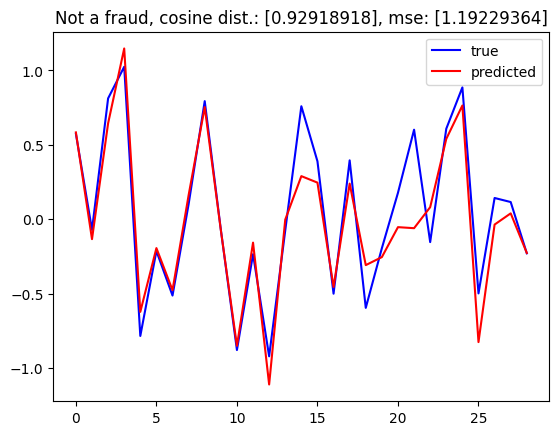

In [47]:
# Choose a random feature vector from the test-set, pass the feature vector through the
# autoencoder and see how well it can reproduce the signal. Here the MSE should be small.
feature_vector = test_features[np.random.choice(test_features.shape[0]), :]
predicted_vector = autoencoder.predict(feature_vector.reshape((1, 29))).flatten()

cos_distance = cosine_distance(feature_vector, predicted_vector)
mse = mse_distance(feature_vector, predicted_vector)

plt.plot(feature_vector, color='blue', label='true')
plt.plot(predicted_vector, color='red', label='predicted')
plt.legend()
plt.title(f'Not a fraud, cosine dist.: {cos_distance}, mse: {mse}')
plt.draw()

1/1 [==============================] - 0s 28ms/step


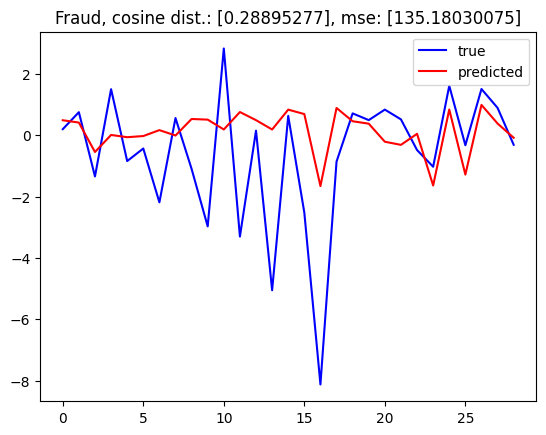

In [48]:
# Choose a random feature vector from the fraud-set, pass the feature vector through the
# autoencoder and see how well it can reproduce the signal. Here the MSE should be large.
feature_vector = fraud_features[np.random.choice(fraud_features.shape[0]), :]
predicted_vector = autoencoder.predict(feature_vector.reshape((1, 29))).flatten()

cos_distance = cosine_distance(feature_vector, predicted_vector)
mse = mse_distance(feature_vector, predicted_vector)

plt.plot(feature_vector, color='blue', label='true')
plt.plot(predicted_vector, color='red', label='predicted')
plt.legend()
plt.title(f'Fraud, cosine dist.: {cos_distance}, mse: {mse}')
plt.draw()

In [49]:
# Join test set and fraud data. The network has not seen either one of these before
combined_features = np.vstack((test_features, fraud_features))
combined_labels = np.vstack((test_labels.reshape(-1, 1), fraud_labels.reshape(-1, 1)))
combined_labels = (combined_labels == 1).flatten()

# Predict features and calculate metrics
predicted_features = autoencoder.predict(combined_features)
cos_distance = cosine_distance(combined_features, predicted_features)
mse = mse_distance(combined_features, predicted_features)

1793/1793 [==============================] - 2s 1ms/step


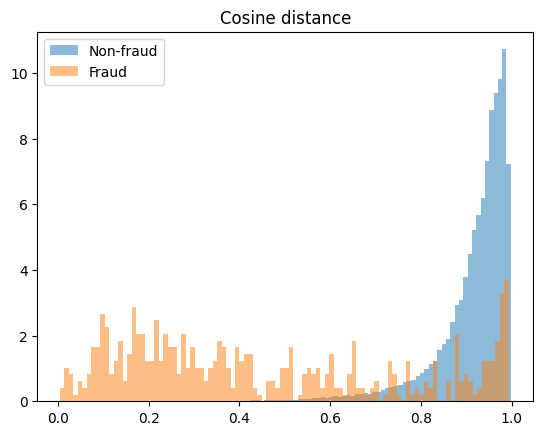

In [50]:
# Plot histograms for cosine distance
plt.hist(cos_distance[combined_labels==False], bins=100, label='Non-fraud', alpha=0.5, density=True)
plt.hist(cos_distance[combined_labels==True], bins=100, label='Fraud', alpha=0.5, density=True)
plt.legend()
plt.title('Cosine distance')
plt.show()

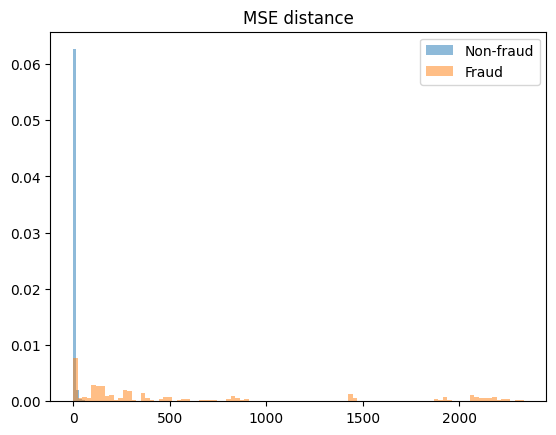

In [51]:
# Plot histograms for cosine distance
plt.hist(mse[combined_labels==False], bins=100, label='Non-fraud', alpha=0.5, density=True)
plt.hist(mse[combined_labels==True], bins=100, label='Fraud', alpha=0.5, density=True)
plt.legend()
plt.title('MSE distance')
plt.show()

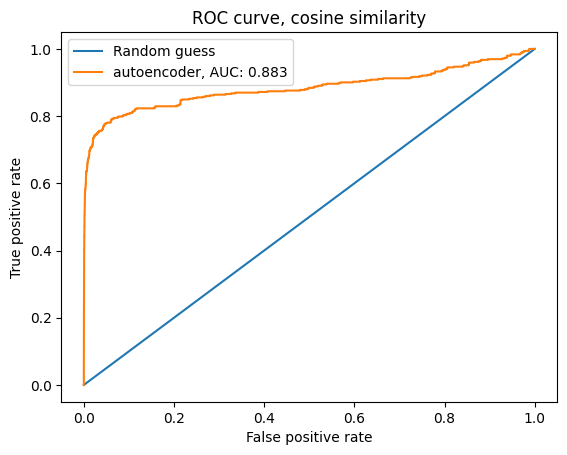

In [52]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# Show Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(combined_labels, 1.0 - cos_distance)
auc_score = roc_auc_score(combined_labels, 1.0 - cos_distance)

plt.plot([0, 1], [0, 1], label='Random guess')
plt.plot(fpr, tpr, label=f'autoencoder, AUC: {auc_score:.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve, cosine similarity')
plt.show()

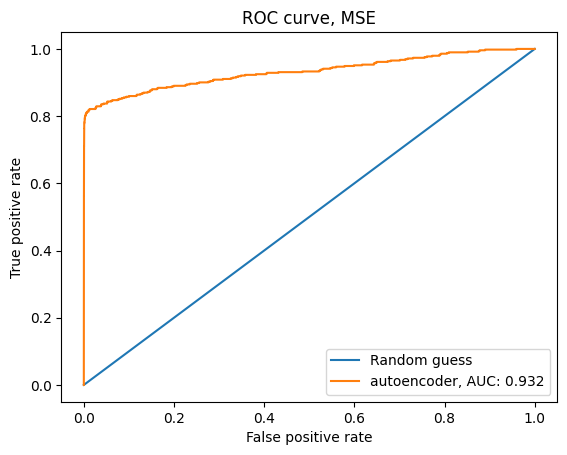

In [53]:
# Show Receiver Operating Characteristic (ROC) curve
fpr, tpr, thresholds = roc_curve(combined_labels, mse)
auc_score = roc_auc_score(combined_labels, mse)

plt.plot([0, 1], [0, 1], label='Random guess')
plt.plot(fpr, tpr, label=f'autoencoder, AUC: {auc_score:.3f}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve, MSE')
plt.show()

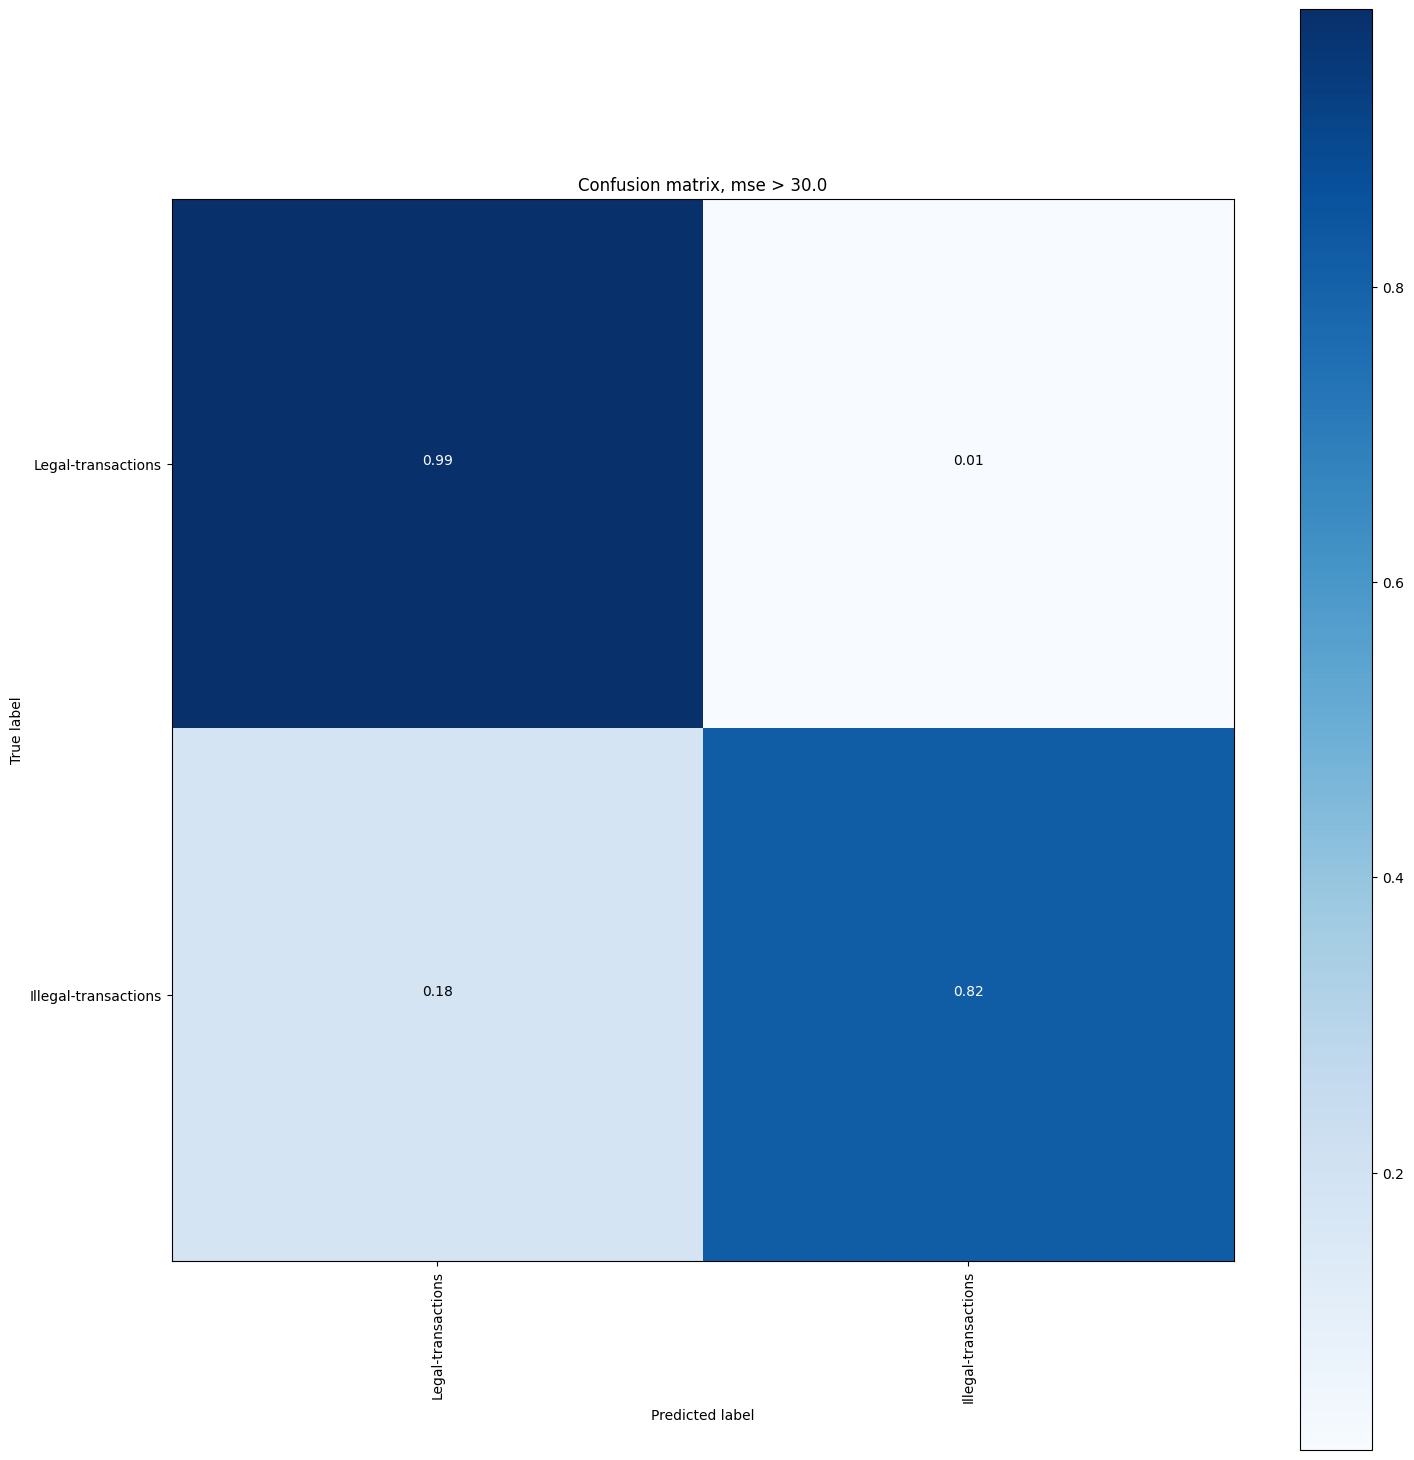

In [54]:
# If the MSE is above the threshold, then the transaction is considered fraudulous
predicted_labels = mse > 30.0

labels = '''Legal-transactions
            Illegal-transactions'''.split()

# Print confusion matrix at the given threshold
cm = confusion_matrix(combined_labels, predicted_labels)
utils.plot_confusion_matrix(cm, labels, normalize=True, title='Confusion matrix, mse > 30.0')